In [1]:
import matplotlib.pyplot as plt
import numpy as np
from qctrlvisualizer import get_qctrl_style
from scipy.linalg import expm

from qctrl import Qctrl

plt.style.use(get_qctrl_style())

# Define standard matrices
sigma_x = np.array([[0, 1], [1, 0]], dtype=np.complex)
sigma_y = np.array([[0, -1j], [1j, 0]], dtype=np.complex)
sigma_z = np.array([[1, 0], [0, -1]], dtype=np.complex)

# Start a session with the API
qctrl = Qctrl()

In [28]:
# Define parameters to be estimated
# actual_sigma = 300e-9  # s
# actual_mu = 100e-9  # s
actual_a = 1.7
# actual_b = -0.5

actual_omega = 0

In [11]:
total_duration = 1000e-9  # s

# Define parameters of the Gaussian pulses to probe the filter
max_width = total_duration / 6.0
mean_values = np.linspace(max_width, total_duration - max_width, 6)
width_values = np.linspace(max_width / 8.0, max_width / 2.0, 4)

# Define sampled times
segments = 150
t_values = np.linspace(0.0, total_duration, segments + 1)

In [18]:
def population(pulse_widths, pulse_means, filter_omega, values=np.array([np.pi])):
    """
    Calculates the transfer probability between states |0> and |1> for a
    batch of Gaussian pulses with given widths and means, while applying
    a Gaussian filter to the pulses with a given cutoff frequency and offset.
    """

    def gaussian_pulse(t, mean, width):
        return np.exp(-0.5 * ((t - mean) / width) ** 2.0) * np.sqrt(
            0.5 * np.pi / width ** 2.0
        )

    with qctrl.create_graph() as graph:
        alpha = qctrl.operations.pwc_signal(
            gaussian_pulse(
                t_values[None, None, :],
                pulse_means[None, :, None],
                pulse_widths[:, None, None],
            ),
            total_duration,
        )

        # Create time dependent \Omega(t)
        drive = qctrl.operations.pwc_signal(duration=total_duration, values=values)

        shift = qctrl.operations.stf_operator(
            signal=drive,
            operator=0.5 * sigma_x,
        )

        b = np.array([[0, 1], [0, 0]])  # Lowering operator

#         # Construct Hamiltonian (\Omega(t) b + \Omega^*(t) b^\dagger)/2
#         hamiltonian = qctrl.operations.pwc_operator_hermitian_part(
#             qctrl.operations.pwc_operator(signal=drive, operator=b)
#         )

        population = 1.0 - qctrl.operations.infidelity_stf(
            sample_times=t_values,
            hamiltonian=shift,
            target_operator=qctrl.operations.target(b),
        )
        population.name = "populations"

    graph_result = qctrl.functions.calculate_graph(
        graph=graph,
        output_node_names=["populations"],
    )
    return graph_result.output["populations"]["value"]

In [19]:
populations = population(
    pulse_widths=width_values,
    pulse_means=mean_values,
    filter_omega=actual_omega
)

QctrlArgumentsValueError: The signal must be an Stf.
signal=TensorPwcNodeData(operation=<qctrlcommons.node.wrapper.Operation object at 0x7fdb00825c50>, values_shape=(), durations=array([1.e-06]), batch_shape=())

In [25]:
def population_simple(values=np.array([np.pi]), repetitions=1, duration=total_duration):
    b = np.array([[0, 1], [0, 0]])  # Lowering operator
    initial_state = np.array([[1], [0]])  # Initial state of qubit in |0>

    with qctrl.create_graph() as graph:

        # Create time dependent \Omega(t)
        drive = qctrl.operations.pwc_signal(duration=duration, values=values)

        # Construct Hamiltonian (\Omega(t) b + \Omega^*(t) b^\dagger)/2
        hamiltonian = qctrl.operations.pwc_operator_hermitian_part(
            qctrl.operations.pwc_operator(signal=drive, operator=b)
        )

        # Solve Schrodinger's equation and get total unitary at the end
        unitary = qctrl.operations.time_evolution_operators_pwc(
            hamiltonian=hamiltonian,
            sample_times=np.array([duration]),
        )[-1]
        unitary.name = "unitary"

        # Repeat final unitary
        repeated_unitary = np.eye(2)
        for _ in range(repetitions):
            repeated_unitary = repeated_unitary @ unitary
        repeated_unitary.name = "repeated_unitary"

        # Calculate final state.
        state = repeated_unitary @ initial_state

        # Calculate final populations.
        populations = qctrl.operations.abs(state[:, 0]) ** 2
        # Normalize populations because of numerical precision
        norm = qctrl.operations.sum(populations)
        populations = populations / norm
        populations.name = "populations"

    # Evaluate graph.
    result = qctrl.functions.calculate_graph(
        graph=graph,
        output_node_names=["unitary", "repeated_unitary", "populations"],
    )

    # Extract outputs.
    return result.output["populations"]["value"]

In [26]:
populations = population_simple()

Your task calculate_graph has completed in 3s.


In [29]:
# Create measurement results with some uncertainty associated to them,
# we will estimate the standard deviation of this error as 1% of the population
population_errors = 0.01 * np.ones_like(populations)

measurement_results = (
    actual_a * np.random.normal(loc=populations, scale=population_errors) + actual_b
)

# Rescale error to arbitrary units
measurement_errors = np.abs(actual_a) * population_errors

AssertionError: 

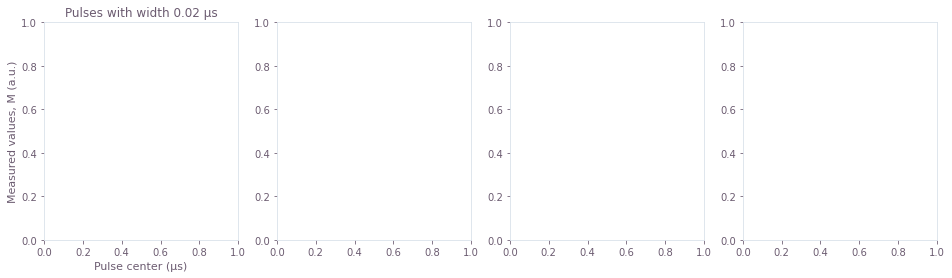

In [30]:
# Plot inputs
fig, axs = plt.subplots(1, 4, figsize=(16, 4))
axs[0].set_ylabel("Measured values, M (a.u.)")
for n in range(len(width_values)):
    axs[n].set_title(f"Pulses with width {width_values[n] * 1e6:.2f} µs")
    axs[n].set_xlabel("Pulse center (µs)")
    axs[n].errorbar(
        mean_values * 1e6,
        measurement_results[n],
        yerr=2.0 * measurement_errors[n],
        fmt="s",
    )

In [32]:
len(measurement_results)

2

In [34]:
populations

array([1.0000000e+00, 2.4674011e-12])